Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded successfully: (60398, 60)


EnglishCountryRegionName,Australia,Canada,France,Germany,United Kingdom,United States
Year,,,,,,
2010,2.090978e+04,3.578270e+03,3.399990e+03,0.000000e+00,6.990982e+02,1.483390e+04
2011,2.563732e+06,5.715718e+05,4.108453e+05,5.205002e+05,5.505912e+05,2.458285e+06
2012,2.128407e+06,3.076045e+05,6.480655e+05,6.086580e+05,7.127010e+05,1.437049e+06
2013,4.339443e+06,1.085633e+06,1.578512e+06,1.761876e+06,2.124007e+06,5.462079e+06
2014,8.507720e+03,9.457620e+03,3.195060e+03,3.277830e+03,3.713640e+03,1.754285e+04


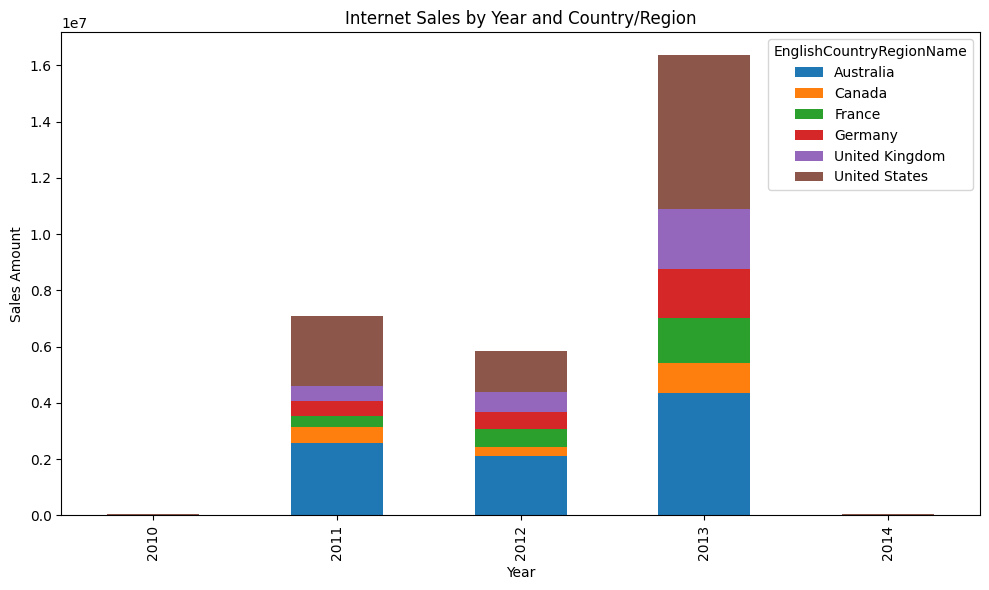

,EnglishCountryRegionName,Gender,count,mean,min,max,std
0,Australia,F,6685,67060.583396,10000,160000,30613.956169
1,Australia,M,6660,65412.912913,10000,170000,32550.778171
2,Canada,F,3648,58651.315789,10000,170000,19435.158438
3,Canada,M,3972,61460.221551,10000,170000,22702.851581
4,France,F,2781,39367.134124,10000,110000,28421.836245
5,France,M,2777,39805.545553,10000,110000,28665.660622
6,Germany,F,2820,48287.234043,10000,130000,37622.814569
7,Germany,M,2805,46730.837790,10000,130000,37487.619366
8,United Kingdom,F,3401,56518.670979,10000,170000,51130.689140
9,United Kingdom,M,3505,55771.754636,10000,170000,50963.707551


Top Product: Mountain-200 Black, 46
Average Unit Price ≈ $2,215.27


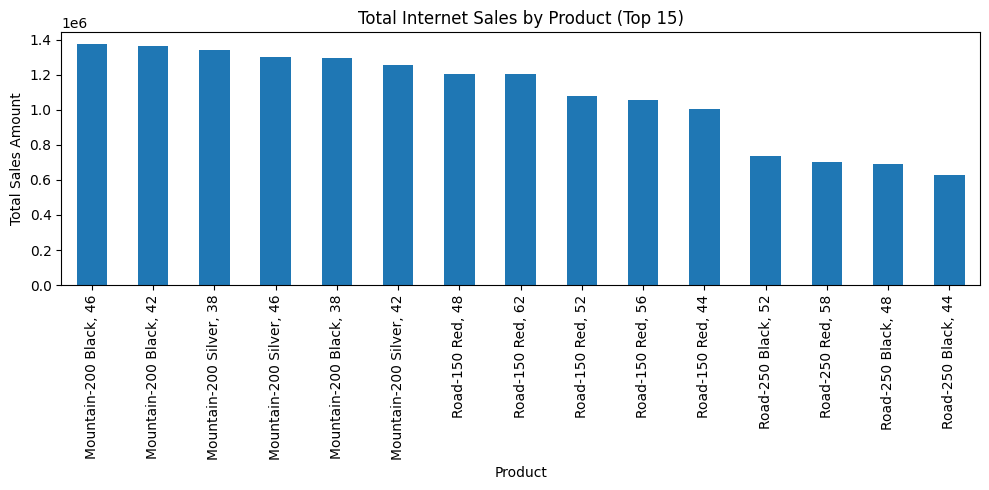

,HomeOwnerFlag,avg_order_value,total_sales,num_orders
0,0,479.882744,8.973327e+06,18699
1,1,488.869033,2.038535e+07,41699


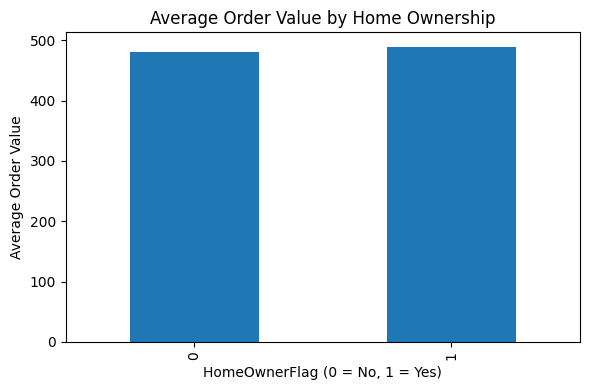

,HomeOwnerFlag,count,mean,median,min,max,std
0,0,5982,1500.054735,209.96,2.29,13265.99,2046.878581
1,1,12502,1630.567093,342.00,2.29,13295.38,2159.068509



Notes & Limitations:
- Dataset is fictitious, for learning only.
- No explicit Product Category; product name used as proxy.
- Year derived from OrderDate; malformed dates ignored.


In [5]:
# Adventure Works Internet Sales – Analysis (Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/MSSP6070/data/InternetSales (2).csv",
                 encoding="latin1", low_memory=False)

print("✅ Loaded successfully:", df.shape)
df.head()


# Define columns
order_date_col = "OrderDate"
sales_amount_col = "SalesAmount"
country_col = "EnglishCountryRegionName"
yearly_income_col = "YearlyIncome"
gender_col = "Gender"
homeowner_col = "HouseOwnerFlag"
product_name_col = "EnglishProductName"
unit_price_col = "UnitPrice"
order_qty_col = "OrderQuantity"
customer_id_col = "CustomerKey"

# Prepare columns
df[order_date_col] = pd.to_datetime(df[order_date_col], errors="coerce")
df["Year"] = df[order_date_col].dt.year
for c in [sales_amount_col, yearly_income_col, unit_price_col, order_qty_col]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 1️⃣ Internet sales by year & country/region
sales_year_country = (
    df.dropna(subset=["Year"])
      .groupby(["Year", country_col])[sales_amount_col]
      .sum()
      .reset_index()
)
pivot_sales_year_country = (
    sales_year_country.pivot(index="Year", columns=country_col, values=sales_amount_col)
    .fillna(0)
)
display(pivot_sales_year_country)

ax = pivot_sales_year_country.plot(kind="bar", stacked=True, figsize=(10,6))
ax.set_title("Internet Sales by Year and Country/Region")
ax.set_xlabel("Year")
ax.set_ylabel("Sales Amount")
plt.tight_layout()
plt.show()

# 2️⃣ Yearly Income summary by country & gender
income_stats = (
    df.dropna(subset=[yearly_income_col])
      .groupby([country_col, gender_col])[yearly_income_col]
      .agg(["count", "mean", "min", "max", "std"])
      .reset_index()
)
display(income_stats.sort_values([country_col, gender_col]))

# 3️⃣ Top product (proxy for category) & average price
product_sales = (
    df.groupby(product_name_col)[sales_amount_col]
      .sum()
      .sort_values(ascending=False)
      .to_frame("TotalSales")
      .reset_index()
)
top_product = product_sales.iloc[0, 0]
avg_price_top = df.loc[df[product_name_col]==top_product, unit_price_col].mean()

print(f"Top Product: {top_product}")
print(f"Average Unit Price ≈ ${avg_price_top:,.2f}")

ax = (
    product_sales.head(15)
      .set_index(product_name_col)["TotalSales"]
      .plot(kind="bar", figsize=(10,5))
)
ax.set_title("Total Internet Sales by Product (Top 15)")
ax.set_xlabel("Product")
ax.set_ylabel("Total Sales Amount")
plt.tight_layout()
plt.show()

# 4️⃣ Does owning a home make a difference?
order_level = (
    df.groupby(homeowner_col)[sales_amount_col]
      .agg(avg_order_value="mean", total_sales="sum", num_orders="count")
      .reset_index()
      .rename(columns={homeowner_col: "HomeOwnerFlag"})
)
display(order_level)

ax = (
    order_level.set_index("HomeOwnerFlag")["avg_order_value"]
      .plot(kind="bar", figsize=(6,4))
)
ax.set_title("Average Order Value by Home Ownership")
ax.set_xlabel("HomeOwnerFlag (0 = No, 1 = Yes)")
ax.set_ylabel("Average Order Value")
plt.tight_layout()
plt.show()

customer_level = (
    df.groupby([customer_id_col, homeowner_col])[sales_amount_col]
      .sum()
      .reset_index()
      .groupby(homeowner_col)[sales_amount_col]
      .agg(["count","mean","median","min","max","std"])
      .reset_index()
      .rename(columns={homeowner_col: "HomeOwnerFlag"})
)
display(customer_level)

print("\nNotes & Limitations:")
print("- Dataset is fictitious, for learning only.")
print("- No explicit Product Category; product name used as proxy.")
print("- Year derived from OrderDate; malformed dates ignored.")
